<a href="https://colab.research.google.com/github/Samuel-Ovuehor/Python-Code/blob/main/TrafficEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterstats
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 7.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import shapely as shp
import rasterstats as rs
import requests
import json


limit the maximum number of printed rows to six, to save space

In [4]:
pd.set_option('display.max_rows', 6)

The following code loads the file with the summary of scoot loop sensors in Hull

In [5]:
# Step 1: Get the JSON data from the URL
url = "https://opendata.hullcc.gov.uk/dataset/30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3/resource/90e1cce0-295e-4fa7-aa21-ebc4f3e8e8d4/download/scoot_loop_resources_full.json"
response = requests.get(url)

# Step 2: Convert the JSON response to a Python object
my_response = response.json()

# Step 3: Create a DataFrame from the JSON data
my_data = pd.json_normalize(my_response)

# Step 4: Filter out rows where longitude is 0
my_data = my_data[my_data['longitude'] != 0]

# Display the resulting DataFrame
print(my_data.head())


        id                           resource_id  \
0  9601773  155c6177-a011-41a0-b8d6-2232fc07aeeb   
1  9601774  d8b65526-90e6-4dcc-8386-aeb827b124d5   
2  9601775  80cf0bd9-a782-42a7-a45f-7851483aa9b6   
3  9601776  c93c3abe-abfe-48f5-a99b-6dd958f09fc2   
4  9601777  2aeb1f0d-5daf-4304-9b50-d3436c72a52a   

                             package_id     name  \
0  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111A   
1  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111B   
2  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111C   
3  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111D   
4  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111E   

                                         description  longitude   latitude  
0  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373631  53.745063  
1  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373455  53.744752  
2  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373497  53.744744  
3  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.370860  5

In [28]:
my_data.head()

,id,resource_id,package_id,name,description,longitude,latitude,geometry
0,9601773,155c6177-a011-41a0-b8d6-2232fc07aeeb,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111A,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373631,53.745063,POINT (-0.373631 53.745063)
1,9601774,d8b65526-90e6-4dcc-8386-aeb827b124d5,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111B,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373455,53.744752,POINT (-0.373455 53.744752)
2,9601775,80cf0bd9-a782-42a7-a45f-7851483aa9b6,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111C,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373497,53.744744,POINT (-0.373497 53.744744)
3,9601776,c93c3abe-abfe-48f5-a99b-6dd958f09fc2,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111D,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.370860,53.743819,POINT (-0.37086 53.743819)
4,9601777,2aeb1f0d-5daf-4304-9b50-d3436c72a52a,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111E,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.372954,53.743365,POINT (-0.372954 53.743365)


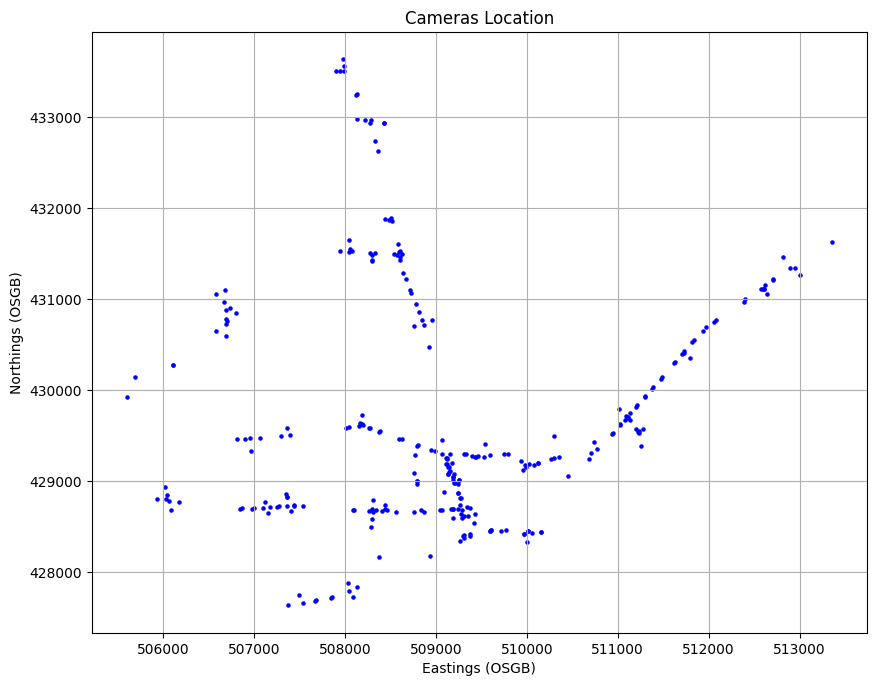

In [6]:
from shapely.geometry import Point

# Step 1: Convert to GeoDataFrame
# Create geometry from latitude and longitude
my_data['geometry'] = my_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Create a GeoDataFrame
sf_cameras = gpd.GeoDataFrame(my_data, geometry='geometry', crs=4326)

# Step 2: Transform the coordinate reference system to EPSG:27700
sf_cameras = sf_cameras.to_crs(epsg=27700)

# Step 3: Plot using Matplotlib
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add basemap (you might need to customize this part or use additional libraries)
# Here we will just plot the points for simplicity
sf_cameras.plot(ax=ax, color='blue', markersize=5)

# Show the plot
plt.title("Cameras Location")
plt.xlabel("Eastings (OSGB)")
plt.ylabel("Northings (OSGB)")
plt.grid()
plt.show()


There are some issues with the coordinates of some sites. The following code fixes the problem

In [7]:
my_data.loc[my_data['latitude'] < 0, ['longitude', 'latitude']] = my_data.loc[my_data['latitude'] < 0, ['longitude', 'latitude']].iloc[::-1].values


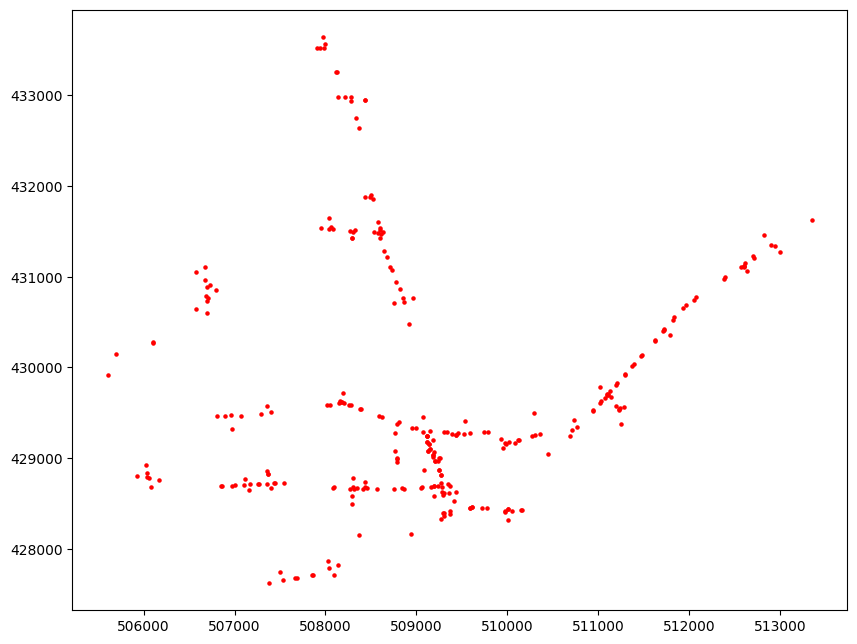

In [9]:
import re

# Replace and split the description column
my_data['description'] = my_data['description'].str.replace("HE SITE - ", "HE SITE _ ")
my_data[['desc', 'direction', 'url', 'coord']] = my_data['description'].str.split(' - ', expand=True)

# Drop the 'coord' column
my_data_expanded = my_data.drop(columns=['coord'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    my_data_expanded,
    geometry=gpd.points_from_xy(my_data_expanded['longitude'], my_data_expanded['latitude']),
    crs="EPSG:4326"
)

# Transform the coordinate reference system to EPSG:27700
gdf = gdf.to_crs(epsg=27700)

# Plot using geopandas (or use contextily for a basemap)
ax = gdf.plot(marker='o', color='red', markersize=5, figsize=(10, 10))

Grouping sensors

<ipython-input-13-18ac1ac0e45b>:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([xlim[0] + (xlim[1] - xlim[0]) * zoom_factor, xlim[1] - (xlim[1] - xlim[0]) * zoom_factor])
<ipython-input-13-18ac1ac0e45b>:25: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([ylim[0] + (ylim[1] - ylim[0]) * zoom_factor, ylim[1] - (ylim[1] - ylim[0]) * zoom_factor])


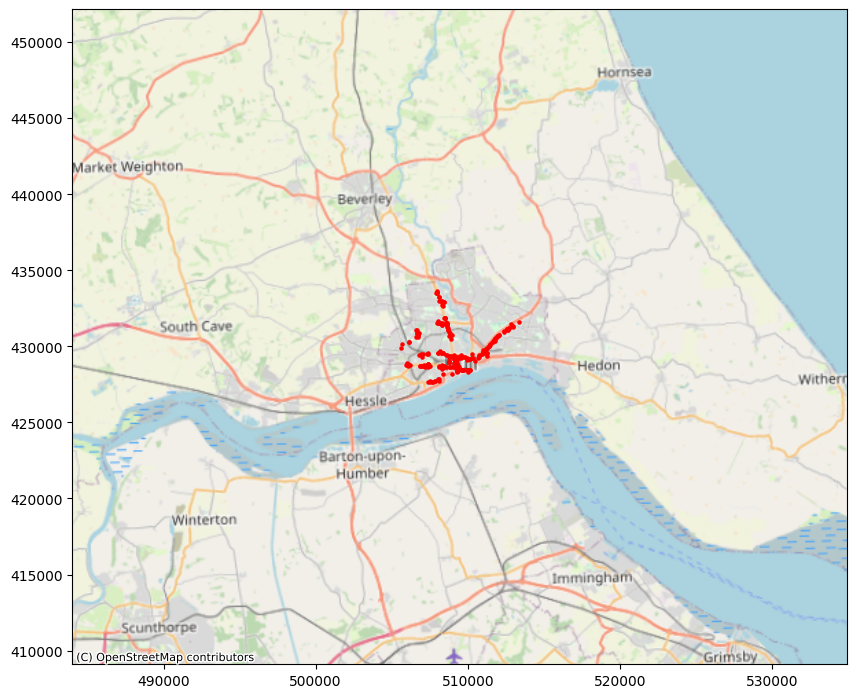

In [13]:
# Buffer the sensor data by 20 units (assuming meters)
sensors_buffer = gdf.buffer(20)

# Filter the buffer GeoDataFrame for specific names
filtered_sensors = gdf[gdf['name'].isin(["N44131F", "N44131X", "N44131H"])]

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer as polygons with some transparency
filtered_sensors_buffer = gpd.GeoDataFrame(geometry=sensors_buffer[gdf['name'].isin(["N44131F", "N44131X", "N44131H"])]).set_crs(gdf.crs)
filtered_sensors_buffer.plot(ax=ax, alpha=0.4, color='blue')

# Plot the original points
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Zoom in or out by adjusting plot limits (xlim and ylim)
# For example, we can zoom by setting the axis limits:
xlim = ax.get_xlim()  # Get current x-axis limits
ylim = ax.get_ylim()  # Get current y-axis limits

# Adjust limits (e.g., zoom in by reducing the range)
zoom_factor = 0.5  # 0.5 for zooming in, >1 for zooming out
ax.set_xlim([xlim[0] + (xlim[1] - xlim[0]) * zoom_factor, xlim[1] - (xlim[1] - xlim[0]) * zoom_factor])
ax.set_ylim([ylim[0] + (ylim[1] - ylim[0]) * zoom_factor, ylim[1] - (ylim[1] - ylim[0]) * zoom_factor])

# Add basemap (OpenStreetMap)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()
